<a href="https://colab.research.google.com/github/jeonggyunH/jeonggyunH/blob/main/Colaboratory%EC%97%90_%EC%98%A4%EC%8B%A0_%EA%B2%83%EC%9D%84_%ED%99%98%EC%98%81%ED%95%A9%EB%8B%88%EB%8B%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

4/4 [==============================] - 0s 6ms/step
1999 0.5799999833106995 0.6399999856948853


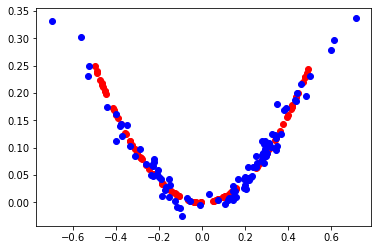

4/4 [==============================] - 0s 4ms/step
3999 0.7400000095367432 0.5099999904632568


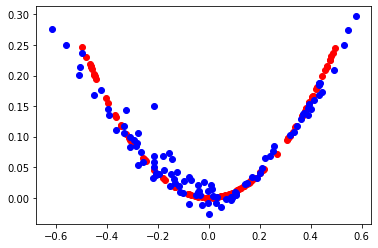

4/4 [==============================] - 0s 6ms/step
5999 0.5400000214576721 0.5400000214576721


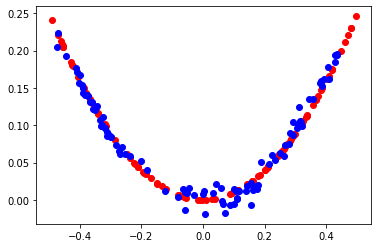

4/4 [==============================] - 0s 3ms/step
7999 0.6499999761581421 0.5199999809265137


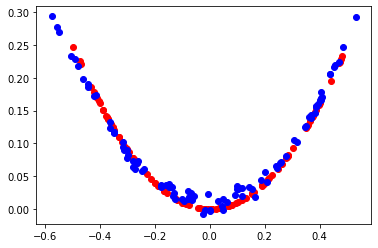

4/4 [==============================] - 0s 6ms/step
9999 0.6800000071525574 0.6100000143051147


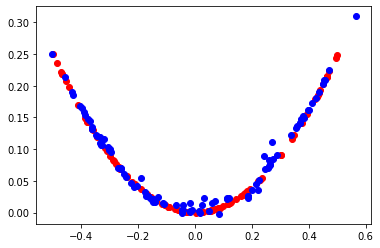

In [3]:
from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

# 생성 모델은 Generator와 Discriminator가 결합된 GAN 모델 학습 시에 학습되고,
# 가짜 Data를 만드는 과정에서 사용된다.
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model

# 분별 모델은 진짜 데이터의 Target값을 1로, 가짜 데이터의 Target값을 0으로 하여 학습 시킨다
# 학습된 모델은 GAN모델에서 생성자와 결합된다.
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# 분별자는 따로 학습되고 있어 가중치를 업데이트 하지 않는다 (판별용으로만 사용)
# GAN 모델에서는 생성자의 가중치만 업데이트 한다.
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

  # 실제 데이터를 생성해 내는 부분 (X, X^2)의 값을 만들고 실제 데이터이므로 Target 값은 True로 둔다
def generate_real_samples(n):
	# generate inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1))
	return X, y
    
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input
 
# 가짜 데이터를 만드는 부분. GAN에서 학습되는 Generator로 가공의 값을 만들고
# Target은 가짜이므로 False로 둔다
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	y = zeros((n, 1))
	return X,y

  # 분별자 학습
def train_discriminator(model, n_epochs=1000, n_batch=128):
	half_batch = int(n_batch / 2)
	# run epochs manually
	for i in range(n_epochs):
		# generate real examples
		X_real, y_real = generate_real_samples(half_batch)
		# update model
		model.train_on_batch(X_real, y_real)
		# generate fake examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update model
		model.train_on_batch(X_fake, y_fake)
		# evaluate the model
		_, acc_real = model.evaluate(X_real, y_real, verbose=0)
		_, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
		print(i, acc_real, acc_fake)
        
# GAN 모델 학습
def train_gan(gan_model, latent_dim, n_epochs=10000, n_batch=128):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
  
  # 중간의 결과를 보여주는 부분으로 실제 데이터와 가짜 데이터를 임의로 하나씩 생성해 내어 분별자로 해당 데이터가 
# 얼마나 진짜와 가까운 지(accuracy)를 출력하고 차트에 생성된 데이터를 표시함
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
	pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	pyplot.show()


def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# 실제 데이터를 생성하고
		x_real, y_real = generate_real_samples(half_batch)
		# 가짜 데이터는 Generator의 Predict로 만들어 낸다
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# 분별자(discriminator)를 생성한 데이터로 학습하고
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# GAN모델을 통해 Generator를 학습 시킨다.
		gan_model.train_on_batch(x_gan, y_gan)
		# 중간의 결과물들을 출력
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim)
            
# 함수를 호출해 모델을 정의하고 train 실행
latent_dim = 5
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
train(generator, discriminator, gan_model, latent_dim)

In [26]:
import numpy as np
import pandas as pd
%matplotlib inline
import os
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense

from numpy.random import randn
from matplotlib import pyplot
data = pd.read_csv('/content/diabetes.csv')
# data = pd.read_csv('/Iris.csv')
print (data.shape)
print (data.tail())
print (data.columns)



(768, 9)
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


In [7]:
data.columns


Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [8]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [9]:
data.shape

(768, 9)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [11]:
data.Outcome.unique()

array([1, 0])

In [13]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']

label = ['Outcome']
X = data[features]
y = data[label]
print (y)

     Outcome
0          1
1          0
2          1
3          0
4          1
..       ...
763        0
764        0
765        0
766        1
767        0

[768 rows x 1 columns]


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X_true_train, X_true_test, y_true_train, y_true_test = train_test_split(X, y, test_size=0.30, random_state=42)
clf_true = RandomForestClassifier(n_estimators=100)
clf_true.fit(X_true_train,y_true_train)

y_true_pred=clf_true.predict(X_true_test)
print("Base Accuracy:",metrics.accuracy_score(y_true_test, y_true_pred))
print("Base classification report:",metrics.classification_report(y_true_test, y_true_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Base Accuracy: 0.7619047619047619
Base classification report:               precision    recall  f1-score   support

           0       0.82      0.81      0.82       151
           1       0.65      0.68      0.66        80

    accuracy                           0.76       231
   macro avg       0.74      0.74      0.74       231
weighted avg       0.76      0.76      0.76       231



In [15]:
X.shape

(768, 8)

In [16]:
data.shape

(768, 9)

In [17]:
print (y_true_test)

     Outcome
668        0
324        0
624        0
690        0
473        0
..       ...
619        1
198        1
538        0
329        0
302        0

[231 rows x 1 columns]


In [20]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

  # use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = np.zeros((n_samples, 1))
	return X, y

  # generate n real samples with class labels
def generate_real_samples(n):
  X = data.sample(n)

  #generate class labels
  y = np.ones((n, 1))
  return X, y

  # define the standalone generator model
def define_generator(latent_dim, n_outputs=9):
  model = Sequential()
  model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
  model.add(Dense(30, activation='relu'))
  # model.add(Dense(n_outputs, activation='sigmoid'))
  model.add(Dense(n_outputs, activation='linear'))
  return model



In [21]:
generator1 = define_generator(10, 9)
generator1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 15)                165       
                                                                 
 dense_5 (Dense)             (None, 30)                480       
                                                                 
 dense_6 (Dense)             (None, 9)                 279       
                                                                 
Total params: 924
Trainable params: 924
Non-trainable params: 0
_________________________________________________________________


In [27]:
# from keras.layers import Reshape
# from keras.layers import Flatten
# from keras.layers import Conv2D
# from keras.layers import Conv2DTranspose
# from keras.layers import LeakyReLU
# from keras.layers import BatchNormalization
# from keras.initializers import RandomNormal
# from matplotlib import pyplot

In [28]:
# define the standalone discriminator model
def define_discriminator(n_inputs=9):
  model = Sequential()
  # model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer='he_uniform', input_shape=n_inputs))
  # model.add(BatchNormalization())
  # model.add(LeakyReLU(alpha=0.2))
  # model.add(Dense(25, activation='relu'))
  model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
	# compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [22]:
discriminator1 = define_discriminator(9)
discriminator1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 25)                250       
                                                                 
 dense_8 (Dense)             (None, 1)                 26        
                                                                 
Total params: 276
Trainable params: 276
Non-trainable params: 0
_________________________________________________________________


In [29]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

In [30]:
# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist):
	# plot loss
	plt.subplot(1, 1, 1)
	plt.plot(d_hist, label='d')
	plt.plot(g_hist, label='gen')
	# plt.legend()
	# plot discriminator accuracy
	# pyplot.subplot(2, 1, 2)
	# pyplot.plot(a1_hist, label='acc-real')
	# pyplot.plot(a2_hist, label='acc-fake')
	plt.show()
	# save plot to file
	# plt.savefig('results_baseline/plot_line_plot_loss.png')
	plt.close()

In [23]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128):
  
  # determine half the size of one batch, for updating the discriminator
  half_batch = int(n_batch / 2)

  d_history = []
  g_history = []
  
  # manually enumerate epochs
  for epoch in range(n_epochs):
    # prepare real samples
    x_real, y_real = generate_real_samples(half_batch)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    # update discriminator
    d_loss_real, d_real_acc = d_model.train_on_batch(x_real, y_real)
    d_loss_fake, d_fake_acc = d_model.train_on_batch(x_fake, y_fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # prepare points in latent space as input for the generator
    x_gan = generate_latent_points(latent_dim, n_batch)
    
    # create inverted labels for the fake samples
    y_gan = np.ones((n_batch, 1))
    
    # update the generator via the discriminator's error
    g_loss_fake = gan_model.train_on_batch(x_gan, y_gan)

    print('>%d, d1=%.3f, d2=%.3f d=%.3f g=%.3f' % (epoch+1, d_loss_real, d_loss_fake, d_loss,  g_loss_fake))
    d_history.append(d_loss)
    g_history.append(g_loss_fake)

  plot_history(d_history, g_history)

    # if i==999:
    #   np.savetxt("new_X.csv", X, delimiter=",")
    
    # evaluate the model every n_eval epochs
    # if (i+1) % n_eval == 0:
    #   summarize_performance(i, g_model, d_model, latent_dim)
  g_model.save('trained_generated_model_20210205_v3.h5')

In [24]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
  # scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], color='red')
	pyplot.scatter(x_fake[:, 0], color='blue')
	pyplot.show()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
2/2 [==============================] - 0s 5ms/step
>7501, d1=1.238, d2=1.088 d=1.163 g=0.981
2/2 [==============================] - 0s 8ms/step
>7502, d1=1.457, d2=0.831 d=1.144 g=0.773
2/2 [==============================] - 0s 12ms/step
>7503, d1=1.205, d2=1.128 d=1.167 g=0.634
2/2 [==============================] - 0s 5ms/step
>7504, d1=0.844, d2=1.329 d=1.086 g=0.759
2/2 [==============================] - 0s 5ms/step
>7505, d1=0.691, d2=0.793 d=0.742 g=1.124
2/2 [==============================] - 0s 4ms/step
>7506, d1=0.917, d2=0.758 d=0.837 g=1.289
2/2 [==============================] - 0s 5ms/step
>7507, d1=0.874, d2=0.398 d=0.636 g=1.321
2/2 [==============================] - 0s 6ms/step
>7508, d1=0.679, d2=0.545 d=0.612 g=1.393
2/2 [==============================] - 0s 9ms/step
>7509, d1=0.478, d2=0.514 d=0.496 g=1.418
2/2 [==============================] - 0s 5ms/step
>7510, d1=0.341, d2=0.428 d=0.385 g=1.666
2/2 [============================

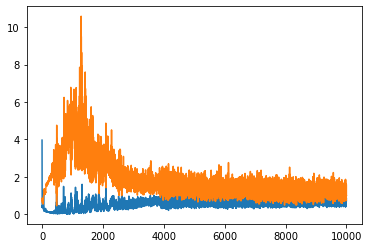

In [31]:
# size of the latent space
latent_dim = 10
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)